# Reduced Depths

**Provides:**  
Blast depths reduced by dynamic crater evolution as measured from peak pressure
of acoustic signal.

**Needs:** to run after `mv-and-clean_byu-mics-summ.ipynb`.

In [1]:
#%matplotlib qt
%matplotlib inline
import pandas as pd
import numpy as np
import asdf
import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib.gridspec as gridspec

import datarepo

plt.rc('text', usetex=True)
plt.rc('font', size=16)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
plt.rc('figure', figsize=(12, 9))

In [2]:
pltt = sbn.color_palette(['#000000', '#2271B2', '#D55E00', '#359B73', '#E20134',
                          '#A40122'])
pltt

[(0.0, 0.0, 0.0),
 (0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333)]

In [3]:
byu_ch = datarepo.byu_ch
byu_mics = datarepo.get_byu_mics()
byu_mics_summ = datarepo.get_byu_mics_summ()

## Crater & Blast Parameters

In [4]:
DBOPT = 3.85e-3
DB0 = 7.62e-4
dr = DB0 / DBOPT
dr

0.19792207792207792

In [5]:
SPEC_EN = 4.85E+6   # specific energy of Pentex / J per kg
EBLAST = .09 * SPEC_EN
OT = 1 / 3
EBTOT = EBLAST ** OT

## Scaled Depth Dependency


Peak pressure dependency on scaled depth:

$$
p_\text{p} \simeq p_{\text{p},0}\,e^{-\bar{d}/\bar{d}_0}
$$

Two separately measured peak pressures $(p_{\text p ,1}, p_{\text p,2})$,
resulting from blasts at scaled depths $(\bar d_1, \bar d_2)$, respectively,
are then related by

$$
p_{\text p,0}
= p_{\text p,1}\, e^{\bar d_1/\bar d_0} = p_{\text p,2}\, e^{\bar d_2/\bar d_0}
$$

If, for example, $\bar d_2$ is not known,...

$$
\bar d_2 = \bar d_0 \ln \frac{p_{\text p,1}}{p_{\text p,2}} + \bar d_1
= \bar d_1 - \bar d_0 \ln \frac{p_{\text p,2}}{p_{\text p,1}}
$$

### `pmax()`, `dbar()`, `db2()`

- `pmax()`: Dependency of $p_\text{p}$ on scaled depth.
- `dbar()`: Dependency of $\bar d$ on peak overpressure (inverse of the above):
$\bar d = -\bar{d}_0\log (p_\text p/p_{\text p, 0})$
- `db2()`: Scaled depth from two separate overpressure measurements $\bar{d}_2$

In [6]:
def pmax(db, pm0):
    """Dependency of pmax on scaled depth.
    
    Parameters
    ----------
    db : array_like
        Scaled depth
    pm0 : float
        Model parameter (Peak overpressure at 0 depth).
    """
    return pm0 * np.exp(-db / DB0)

def dbar(pm, pm0):
    """Dependency of scaled depth on peak overpressure.
    
    Parameters
    ----------
    pm : array_like
        Overpressure.
    pm0 : float
        Model parameter (Peak overpressure at 0 depth).
    """
    return -DB0 * np.log(pm / pm0)

def db2(p1, p2, db1):
    """Scaled depth from two separate overpressure measurements.
    
    Parameters
    ----------
    p1, p2 : array_like
        Overpressures
    db1 : array_like
        Scaled depth corresponding to p1.
    """
    return db1 - DB0 * np.log(p2 / p1)

## Data

The peak data summary of BYU's microphones is provided by the BYU group. The summary data were 'cleaned' from the not-working channels listed below, and then stored as `summ`-key in the `byu-mics.asdf` store.

- Bad channels 2, 10, 20, 23
- pad 1: channel 0, 1
- pad 2: channel 11
- pad 3: channels 21, 25, 29
- pad 4: channel 7

In [7]:
data = byu_mics_summ
data.head()

pad  ch  blast  pmax  tmax  pmin  tmin    noise  ts  tarr  ...  hlabel  \
0    1   0      1   0.0   0.0   0.0   0.0  0.03412 NaN   NaN  ...       -   
1    1   0      2   0.0   0.0   0.0   0.0  0.03412 NaN   NaN  ...       -   
2    1   0      3   0.0   0.0   0.0   0.0  0.03412 NaN   NaN  ...       -   
3    1   0      4   0.0   0.0   0.0   0.0  0.03412 NaN   NaN  ...       -   
4    1   0      5   0.0   0.0   0.0   0.0  0.03412 NaN   NaN  ...       -   

   ppf46  alpha  depth      dbar   dredbar    t          c  Ea  σEa  
0    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
1    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
2    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
3    NaN    NaN    0.6  0.007910       NaN  1.5  341.29036 NaN  NaN  
4    NaN    NaN    0.6  0.007910       NaN  1.5  341.29036 NaN  NaN  

[5 rows x 31 columns]

Channels used here:

In [8]:
channels = np.unique(data.ch)
channels

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 24, 25, 26, 27, 28, 29])

Set vanishing values to `nan` to omit `ZeroDivision` warnings

In [9]:
data.loc[data.pmax == 0., 'pmax'] = np.nan
data.loc[data.pmin == 0., 'pmin'] = np.nan
data.loc[data.tmax == 0., 'tmax'] = np.nan
data.loc[data.tmin == 0., 'tmin'] = np.nan

In [10]:
data.head()

pad  ch  blast  pmax  tmax  pmin  tmin    noise  ts  tarr  ...  hlabel  \
0    1   0      1   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
1    1   0      2   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
2    1   0      3   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
3    1   0      4   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
4    1   0      5   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   

   ppf46  alpha  depth      dbar   dredbar    t          c  Ea  σEa  
0    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
1    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
2    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
3    NaN    NaN    0.6  0.007910       NaN  1.5  341.29036 NaN  NaN  
4    NaN    NaN    0.6  0.007910       NaN  1.5  341.29036 NaN  NaN  

[5 rows x 31 columns]

In [11]:
data.tail()

pad  ch  blast   pmax   tmax   pmin   tmin    noise        ts      tarr  \
607    4  29      2  3.913  2.270 -2.835  2.279  0.04192  2.268611  2.268696   
608    4  29      3  1.076  2.776 -1.400  2.786  0.04192  2.767333  2.770239   
609    4  29      4  2.636  3.273 -3.758  3.280  0.04192  3.268136  3.268638   
610    4  29      5  1.561  3.776 -2.263  3.784  0.04192  3.770260  3.770260   
611    4  29      6  2.605  4.273 -3.665  4.279  0.04192  4.268506  4.268887   

     ...  hlabel     ppf46  alpha  depth      dbar   dredbar    t           c  \
607  ...       h  3.271070   0.05    0.6  0.007910  0.003063  0.5  350.386945   
608  ...       h  1.054867   0.05    0.3  0.003955  0.003955  0.0  350.386945   
609  ...       h  3.353548   0.05    0.6  0.007910  0.003272  0.5  350.386945   
610  ...       h  1.972774   0.05    0.3  0.003955  0.003955  0.0  350.386945   
611  ...       h  3.620879   0.05    0.6  0.007910  0.003565  0.5  350.386945   

     Ea  σEa  
607 NaN  NaN  
608 NaN  NaN  
609 NaN  NaN  
610 NaN  NaN  
611 NaN  NaN  

[5 rows x 31 columns]

In [12]:
data.head()

pad  ch  blast  pmax  tmax  pmin  tmin    noise  ts  tarr  ...  hlabel  \
0    1   0      1   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
1    1   0      2   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
2    1   0      3   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
3    1   0      4   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   
4    1   0      5   NaN   NaN   NaN   NaN  0.03412 NaN   NaN  ...       -   

   ppf46  alpha  depth      dbar   dredbar    t          c  Ea  σEa  
0    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
1    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
2    NaN    NaN    0.3  0.003955  0.003955  0.0  341.29036 NaN  NaN  
3    NaN    NaN    0.6  0.007910       NaN  1.5  341.29036 NaN  NaN  
4    NaN    NaN    0.6  0.007910       NaN  1.5  341.29036 NaN  NaN  

[5 rows x 31 columns]

In [13]:
data.tail()

pad  ch  blast   pmax   tmax   pmin   tmin    noise        ts      tarr  \
607    4  29      2  3.913  2.270 -2.835  2.279  0.04192  2.268611  2.268696   
608    4  29      3  1.076  2.776 -1.400  2.786  0.04192  2.767333  2.770239   
609    4  29      4  2.636  3.273 -3.758  3.280  0.04192  3.268136  3.268638   
610    4  29      5  1.561  3.776 -2.263  3.784  0.04192  3.770260  3.770260   
611    4  29      6  2.605  4.273 -3.665  4.279  0.04192  4.268506  4.268887   

     ...  hlabel     ppf46  alpha  depth      dbar   dredbar    t           c  \
607  ...       h  3.271070   0.05    0.6  0.007910  0.003063  0.5  350.386945   
608  ...       h  1.054867   0.05    0.3  0.003955  0.003955  0.0  350.386945   
609  ...       h  3.353548   0.05    0.6  0.007910  0.003272  0.5  350.386945   
610  ...       h  1.972774   0.05    0.3  0.003955  0.003955  0.0  350.386945   
611  ...       h  3.620879   0.05    0.6  0.007910  0.003565  0.5  350.386945   

     Ea  σEa  
607 NaN  NaN  
608 NaN  NaN  
609 NaN  NaN  
610 NaN  NaN  
611 NaN  NaN  

[5 rows x 31 columns]

### Channel 5

In [14]:
ch5 = data.loc[data.ch == 5]

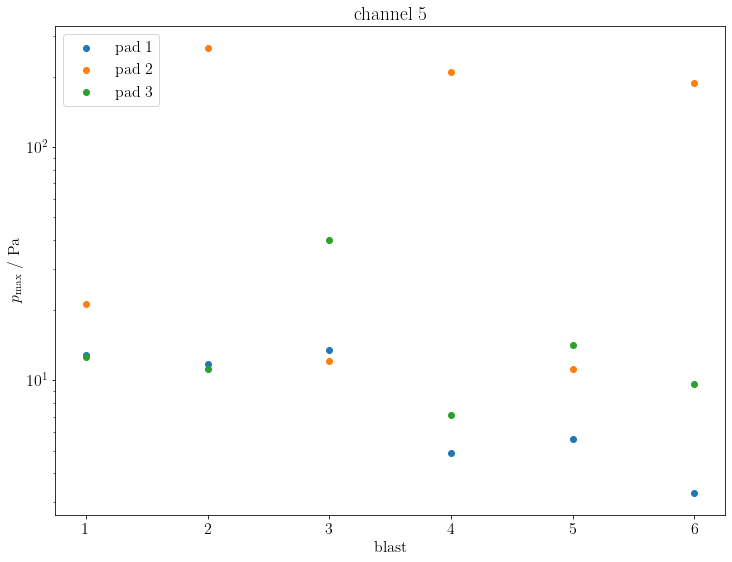

In [15]:
fig, ax = plt.subplots()

ch5p1 = ch5.loc[ch5['pad'] == 1]
ch5p2 = ch5.loc[ch5['pad'] == 2]
ch5p3 = ch5.loc[ch5['pad'] == 3]

ax.scatter(ch5p1.blast, ch5p1.pmax, label='pad 1')
ax.scatter(ch5p2.blast, ch5p2.pmax, label='pad 2')
ax.scatter(ch5p3.blast, ch5p3.pmax, label='pad 3')

ax.set_yscale('log')
# ax.set_ylim(0, None)
ax.set_title(r'channel 5')
ax.set_xlabel(r'blast')
ax.set_ylabel(r'$p_\mathrm{max}\ /\ \mathrm{Pa}$')
ax.legend()
# fig

### Channel 7

In [16]:
ch7 = data.loc[data.ch == 7] 

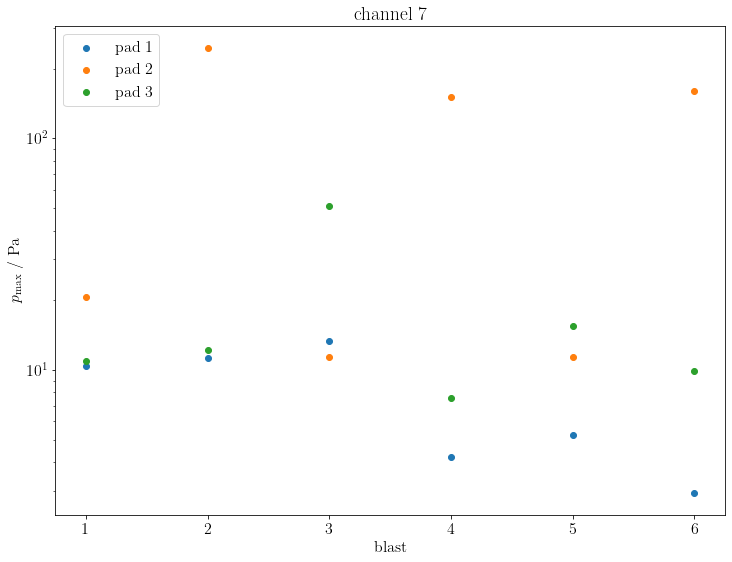

In [17]:
fig, ax = plt.subplots()

ch7p1 = ch7.loc[ch7['pad'] == 1]
ch7p2 = ch7.loc[ch7['pad'] == 2]
ch7p3 = ch7.loc[ch7['pad'] == 3]

ax.scatter(ch7p1.blast, ch7p1.pmax, label='pad 1')
ax.scatter(ch7p2.blast, ch7p2.pmax, label='pad 2')
ax.scatter(ch7p3.blast, ch7p3.pmax, label='pad 3')

ax.set_yscale('log')
# ax.set_ylim(0, None)
ax.set_title(r'channel 7')
ax.set_xlabel(r'blast')
ax.set_ylabel(r'$p_\mathrm{max}\ /\ \mathrm{Pa}$')
ax.legend()
# fig

### Channel 9

In [18]:
ch9 = data.loc[data.ch == 9]

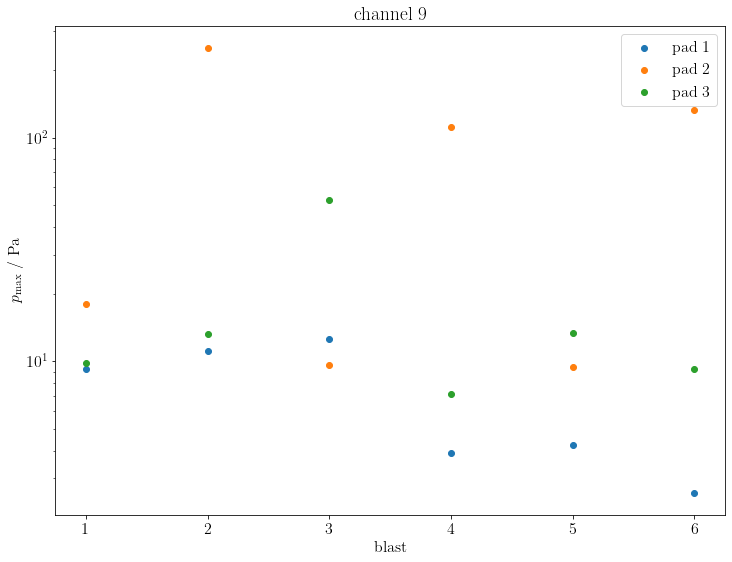

In [19]:
fig, ax = plt.subplots()

ch9p1 = ch9.loc[ch9['pad'] == 1]
ch9p2 = ch9.loc[ch9['pad'] == 2]
ch9p3 = ch9.loc[ch9['pad'] == 3]

ax.scatter(ch9p1.blast, ch9p1.pmax, label='pad 1')
ax.scatter(ch9p2.blast, ch9p2.pmax, label='pad 2')
ax.scatter(ch9p3.blast, ch9p3.pmax, label='pad 3')

ax.set_yscale('log')
# ax.set_ylim(0, None)
ax.set_title(r'channel 9')
ax.set_xlabel(r'blast')
ax.set_ylabel(r'$p_\mathrm{max}\ /\ \mathrm{Pa}$')
ax.legend()
# fig

In [20]:
data.loc[data.blast == 1]

pad  ch  blast    pmax    tmax    pmin    tmin    noise        ts  \
0      1   0      1     NaN     NaN     NaN     NaN  0.03412       NaN   
6      1   1      1     NaN     NaN     NaN     NaN  0.03241       NaN   
12     1   3      1  13.820  0.8733 -12.590  0.8875  0.06713  0.872558   
18     1   4      1  11.570  0.8807 -11.010  0.8951  0.35470  0.879831   
24     1   5      1  12.890  0.8812 -13.410  0.8956  0.08677  0.880512   
..   ...  ..    ...     ...     ...     ...     ...      ...       ...   
582    4  25      1   1.885  1.0000  -1.715  1.4970  0.29130       NaN   
588    4  26      1   1.611  1.6360  -2.065  1.6440  0.01921  1.628670   
594    4  27      1   1.476  1.6380  -1.740  1.6470  0.09542  1.630770   
600    4  28      1   1.526  1.7760  -1.837  1.7850  0.02722  1.768890   
606    4  29      1   1.214  1.7760  -1.569  1.7850  0.04192  1.768074   

         tarr  ...  hlabel      ppf46  alpha  depth      dbar   dredbar    t  \
0         NaN  ...       -        NaN    NaN    0.3  0.003955  0.003955  0.0   
6         NaN  ...       -        NaN    NaN    0.3  0.003955  0.003955  0.0   
12   0.872578  ...       h  14.949408   0.05    0.3  0.003955  0.003955  0.0   
18   0.879854  ...       l  13.203400   0.05    0.3  0.003955  0.003955  0.0   
24   0.880527  ...       h  12.315533   0.05    0.3  0.003955  0.003955  0.0   
..        ...  ...     ...        ...    ...    ...       ...       ...  ...   
582       NaN  ...       -        NaN    NaN    0.3  0.003955  0.003955  0.0   
588  1.629712  ...       l   1.726533   0.05    0.3  0.003955  0.003955  0.0   
594  1.634355  ...       h   1.687374   0.05    0.3  0.003955  0.003955  0.0   
600  1.769429  ...       l   1.682047   0.05    0.3  0.003955  0.003955  0.0   
606  1.769072  ...       h   1.249902   0.05    0.3  0.003955  0.003955  0.0   

              c           Ea         σEa  
0    341.290360          NaN         NaN  
6    341.290360          NaN         NaN  
12   341.290360          NaN         NaN  
18   341.290360          NaN         NaN  
24   341.290360          NaN         NaN  
..          ...          ...         ...  
582  350.386945          NaN         NaN  
588  350.386945  8930.655706  788.362247  
594  350.386945          NaN         NaN  
600  350.386945  8930.655706  788.362247  
606  350.386945          NaN         NaN  

[102 rows x 31 columns]

In [21]:
data['dredbar'] = np.full(len(data), np.nan)

In [22]:
data.loc[data.depth == 0.3, 'dredbar'] = data.loc[data.depth == 0.3, 'dbar']

### charge depths

Write depths and scaled depths to the table

In [23]:
for pad in (1, 3):
    data.loc[np.logical_and(data['pad'] == pad, data.blast < 4), 'depth'] = .3
    data.loc[np.logical_and(data['pad'] == pad, data.blast > 3), 'depth'] = .6

for pad in (2, 4):
    for blast in (1, 3, 5):
        data.loc[
            np.logical_and(data['pad'] == pad, data.blast == blast), 'depth'] = .3
    for blast in (2, 4, 6):
        data.loc[
            np.logical_and(data['pad'] == pad, data.blast == blast), 'depth'] = .6

In [24]:
data['dbar'] = data['depth'] / EBTOT

### reduced depths and relative detonation times

Write the *t* column: time delay after detonation time of charge above.

- in pads 1 and 3 charges located directly above one another detonated 1.5 s apart
- in pads 2 and 4 charges located directly above one another detonated 0.5 s apart

In [25]:
for pad in (1, 3):
    deeps = np.logical_and(data['pad'] == pad, data.blast > 3)
    shallows = np.logical_and(data['pad'] == pad, data.blast < 4)
    data.loc[deeps, 'dredbar'] = db2(data.loc[shallows, 'pmax'].values,
                                     data.loc[deeps, 'pmax'].values,
                                     data.loc[shallows, 'dbar'].values)
    data.loc[shallows, 't'] = 0.
    data.loc[deeps, 't'] = 1.5

for pad in (2, 4):
    deeps = np.logical_and(data['pad'] == pad, data.blast % 2 == 0)
    shallows = np.logical_and(data['pad'] == pad, data.blast % 2 == 1)
    data.loc[deeps, 'dredbar'] = db2(data.loc[shallows, 'pmax'].values,
                                     data.loc[deeps, 'pmax'].values,
                                     data.loc[shallows, 'dbar'].values)
    data.loc[shallows, 't'] = 0.
    data.loc[deeps, 't'] = .5

### Scaled Crater Depth
$\bar{d}_c$ -- taken from single blast shots

In [26]:
DCBAR = 3.92e-3
dc = DCBAR * EBLAST ** OT
dc

0.29735881429937794

## Reduced Depth Plots

### `dredplot()`

In [27]:
ap1 = dict(arrowstyle='->', ls='dashed', color=pltt[3])
ap2 = ap1.copy()
ap2.update(arrowstyle='<->')

bpopt = dict(positions=[0.5, 1.5], sym="", widths=.075)

In [28]:
def drdp_upper(sel1, sel2, ax):
    avg1 = np.average(sel1['dredbar'].values)
    std1 = np.std(sel1['dredbar'].values)
    avg2 = np.average(sel2['dredbar'].values)
    std2 = np.std(sel2['dredbar'].values)
    ax.plot(np.array([0, .5, 1.5]), np.array([.3, .6, .6]) / EBTOT * 1e3,
            'x', color=pltt[4], label=r'$\bar{d}$')
    for sel in (sel1, sel2):
        ls1 = ax.hlines(sel.dredbar * 1e3, sel.t - .05, sel.t + .05,
                         colors='#c5c5c5', linestyles='dashed', linewidths=.5)
    ls1.set_label(r'$\bar{d}_\text{red}$')
    bpopt.update(
        conf_intervals=[(-std1 * 1e3, std1 * 1e3),
                        (-std2 * 1e3, std2 * 1e3)],
        usermedians=[avg1 * 1e3, avg2 * 1e3])
#     print(sel1.dredbar)
#     print(sel2.dredbar)
#     print(bpopt)
    ax.boxplot([sel1.dredbar * 1e3, sel2.dredbar * 1e3], **bpopt)
    ax.text(.6, avg1 * 1e3,
             s=r'$%.2f\,\times10^{-3}\mathrm{m\,J^{-1/3}}$' % (avg1 * 1e3),
             va='center')
    ax.text(1.4, avg2 * 1e3,
            s=r'${%.2f\,\times10^3\mathrm{m\,J^{-1/3}}}$' % (avg2 * 1e3), 
            va='center', ha='right')
    ax.set_ylim(9, -1)
    ax.set_xlim(-.1, 1.6)
    ax.set_ylabel(r'$\bar{d}\ /\ 10^{-3}\mathrm{m\,J^{-1/3}}$')
    ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
    ax.axhline(y=0, ls='dashed', color='gray', label='orig. surf.')
    ax.annotate(text='', xy=(.5, avg1 * 1e3), xytext=(.5, 7.8), arrowprops=ap1)
    ax.annotate(text='', xy=(1.5, avg2 * 1e3), xytext=(1.5, 7.8), arrowprops=ap1)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_xticks([0., .5, 1., 1.5])
    ax.set_xticklabels(['0', '0.5', '1', '1.5'])
    ax.set_zorder(2)
    ax.set_title('a: Scaled depth, and reduced scaled depth vs. time')

In [29]:
def drdp_lower(sel1, sel2, ax, ax3, d):
    ax.set_zorder(1)
    ax.set_title('b: Reduced depth based estimate of transient crater bottom')
    ax.plot([0, .5, 1.5], [-.3, -.6, -.6], 'x', color=pltt[4], label=r'charge loc.')
    for sel in (sel1, sel2):
        ls = ax.hlines(-EBTOT * (sel.dbar - sel.dredbar),
                        sel.t - .05, sel.t +.05,
                        colors='#c5c5c5', linestyles='dashed', linewidths=.5)
    ls.set_label('trans. crater')
    avg1 = -np.average(sel1['dbar'] - sel1['dredbar']) * EBTOT
    std1 = np.std(sel1['dbar'] - sel1['dredbar']) * EBTOT
    avg2 = -np.average(sel2['dbar'] - sel2['dredbar']) * EBTOT
    std2 = np.std(sel2['dbar'] - sel2['dredbar']) * EBTOT
    bpopt.update(conf_intervals=[(-std1, std1), (-std2, std2)],
                 usermedians=[avg1, avg2])
    ax.boxplot(
        [EBTOT * (sel1.dredbar.values - sel1.dbar.values),
         EBTOT * (sel2.dredbar.values - sel2.dbar.values)],
        **bpopt)
    ax.axhline(y=0, ls='dashed', color='gray', lw=.5, label='orig. surf.')
    ax.set_ylim(-.7, .1)
    ax.set_xlim(-.1, 1.6)
    ax.set_ylabel(r'$z\ /\ \mathrm{m}$')
    ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
    ax.set_xticks([0, .5, 1, 1.5])
    ax.set_xticklabels(["0", "0.5", "1", "1.5"])
    ax.annotate(text='', xy=(0.5, avg1), xytext=(.5, -.6), arrowprops=ap2)
    ax.text(.6, avg1, s=r'$%.2f\,\mathrm{m}$' % avg1, va='center')
    ax.text(1.4, avg2, s=r'$%.2f\,\mathrm{m}$' % avg2, va='center', ha='right')
    ax.annotate(text='', xy=(1.5, -.258), xytext=(1.5, -.6), arrowprops=ap2)
    ax.text(0.5, .5 * (-.6 - .466), s=r'$d_\mathrm{red.}$',
             ha='right', va='center', color=pltt[3])
    ax.text(1.5, .5 * (-.6 - .258), s=r'$d_\mathrm{red.}$',
             ha='right', va='center', color=pltt[3])
    ax.plot([1 - d / 3, 1 + d / 3], [-d, d],
             color='black', lw=.5, transform=ax.transAxes, clip_on=False)
    ax.legend(loc='upper left', bbox_to_anchor=(.05, 1.05),
               bbox_transform=ax3.transAxes)

In [30]:
def dredplot(sel, fig, title=""):
    sel1 = sel.loc[np.logical_and(sel.t == 0.5, ~np.isnan(sel.pmax))]
    sel2 = sel.loc[np.logical_and(sel.t == 1.5, ~np.isnan(sel.pmax))]
#     print(sel1)
    
    gs1 = gridspec.GridSpec(1, 4)
    gs2 = gridspec.GridSpec(1, 4)
    ax1 = plt.subplot(gs1[:-1])
    fig.set_size_inches(8, 8)
    gs1.update(top=.9, bottom=.58, right=1, left=.1)
    gs2.update(top=.46, bottom=.1, right=1, left=.1, wspace=.05)
    ax2 = plt.subplot(gs2[:-1])
    ax3 = plt.subplot(gs2[-1])
    sbn.despine(fig=fig)

    ax3.spines['left'].set_visible(False)
    ax3.set_yticks([])
    
    drdp_upper(sel1, sel2, ax1)

    d = .033
    drdp_lower(sel1, sel2, ax2, ax3, d)

    ax3.set_zorder(-1)
    ax3.set_ylim(-.7, .1)
    ax3.set_xlim(9.5, 10.5)
    ax3.set_xticks([])
    ax3.hlines([-dc], 9.6, 10.4, colors='gray', linestyles='dashed', lw=2)
    ax3.text(10, -0.95 * dc, r'final crater bottom', ha='center', va='bottom')
    ax3.text(10, -1.05 * dc, r'of a single shot', ha='center', va='top')
    ax3.plot([-d, d], [-d, d], color='black', lw=.5, transform=ax3.transAxes,
             clip_on=False)
    ax3.set_xlabel(r'$t\to\infty$')
    fig.suptitle(title)
    return fig

## Plot Complete Dataset

In [31]:
pltt

[(0.0, 0.0, 0.0),
 (0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333)]

In [32]:
pltt2 = sbn.color_palette([pltt[0], pltt[2], pltt[3]])
pltt2

[(0.0, 0.0, 0.0),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275)]

In [33]:
sbn.set_palette(pltt2)

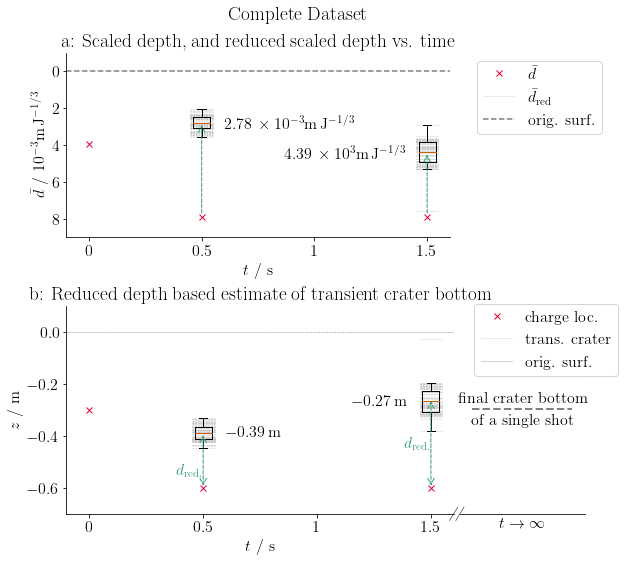

In [34]:
fig = plt.figure()
idx = data['pad'] > 2
fig = dredplot(data.loc[idx], fig, "Complete Dataset")
# fig

## Radial Mic Line

In [35]:
byu_ch['rline']

{'h': array([ 7, 22, 17, 19, 21, 25, 27, 29]),
 'l': array([ 6, 15, 14, 16, 18, 20, 24, 26, 28])}

In [36]:
qstr = ' | '.join(['ch == %d' % ch for ch in byu_ch['rline']['h']]) + ' | ' \
     + ' | '.join(['ch == %d' % ch for ch in byu_ch['rline']['l']])
qstr

'ch == 7 | ch == 22 | ch == 17 | ch == 19 | ch == 21 | ch == 25 | ch == 27 | ch == 29 | ch == 6 | ch == 15 | ch == 14 | ch == 16 | ch == 18 | ch == 20 | ch == 24 | ch == 26 | ch == 28'

### Pads 1 & 2

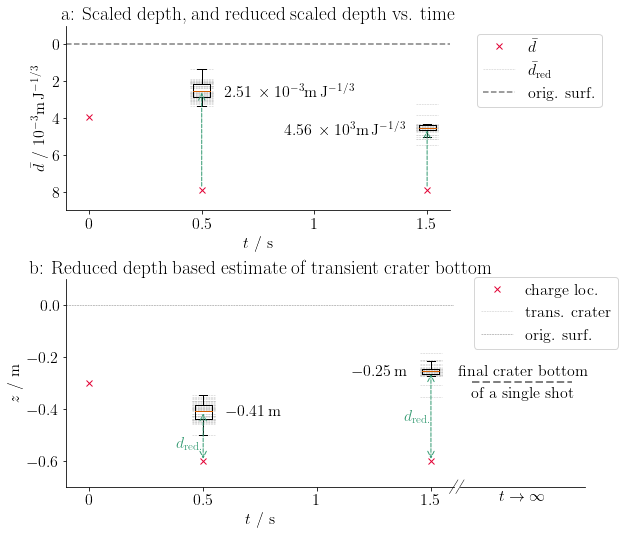

In [37]:
sel = data.loc[data['pad'] < 3]
idx = sel.query(qstr).index

fig = plt.figure()
fig = dredplot(data.loc[idx], fig, '')
# fig

### Pads 3 & 4

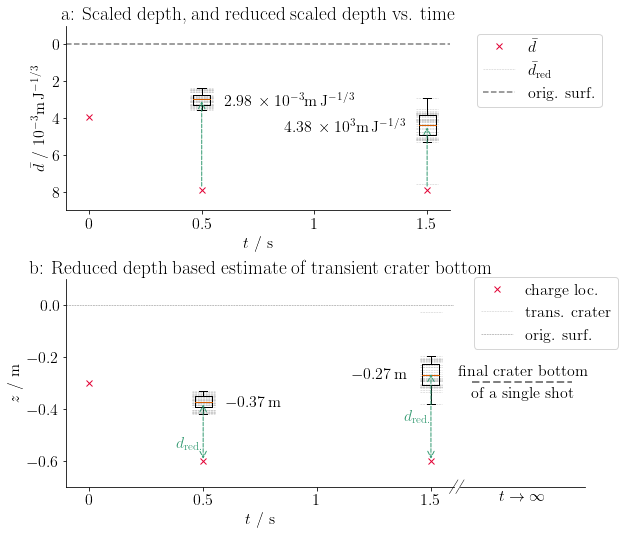

In [38]:
sel = data.loc[data['pad'] > 2]
idx = sel.query(qstr).index

fig = plt.figure()
fig = dredplot(data.loc[idx], fig, '')
# fig

In [39]:
data.loc[idx].query('t == 0.5').loc[:, 'dredbar'].mean()

0.0029762590113329083

In [40]:
data.loc[idx].query('t == 1.5').loc[:, 'dredbar'].mean()

0.004382162915281034

In [41]:
byu_ch['rline']['h']

array([ 7, 22, 17, 19, 21, 25, 27, 29])

### Channel 5

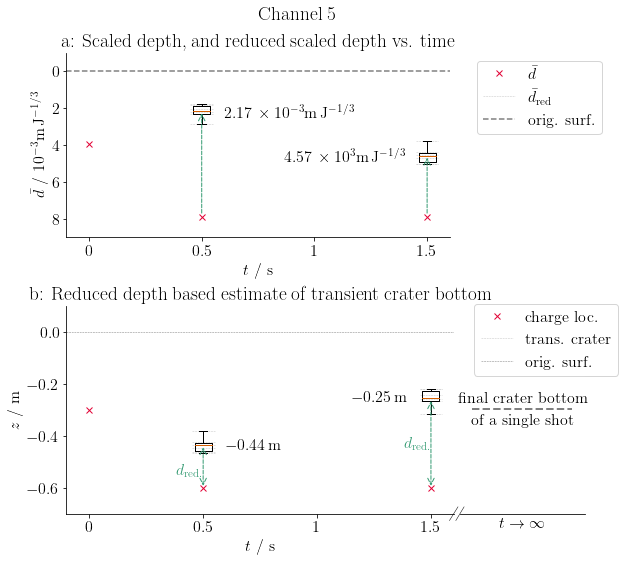

In [42]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 5], fig, "Channel 5")
# fig

### Channel 6

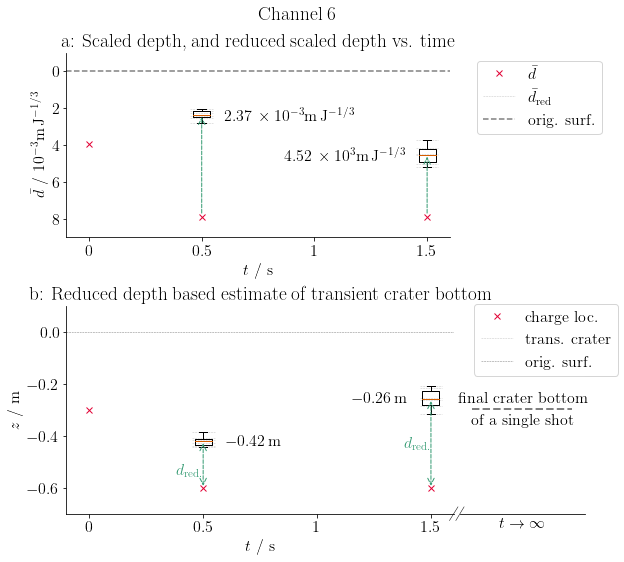

In [43]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 6], fig, "Channel 6")
# fig

### Channel 7

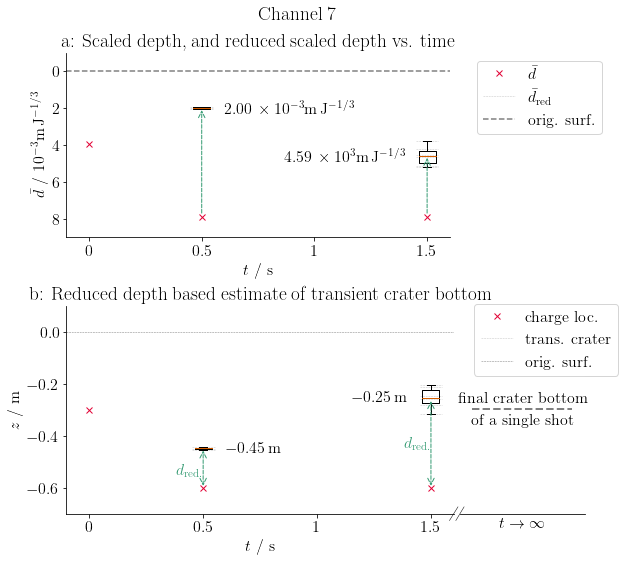

In [44]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 7], fig, "Channel 7")
# fig

### Channel 8

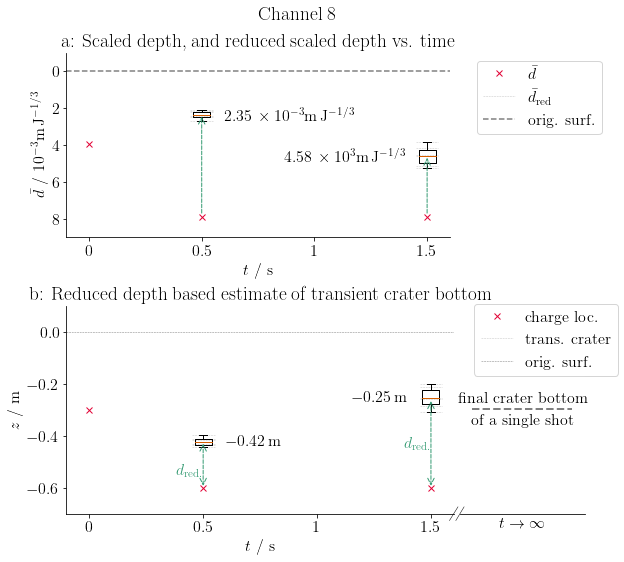

In [45]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 8], fig, "Channel 8")
# fig

### Channel 9

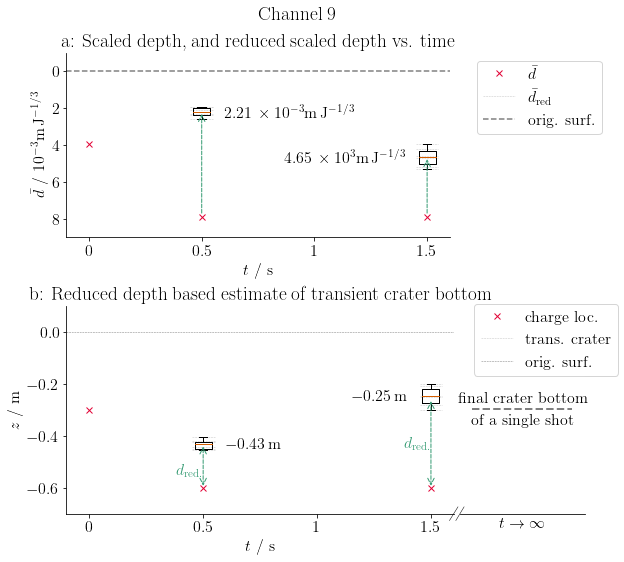

In [46]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 9], fig, "Channel 9")
# fig

### Channel 11

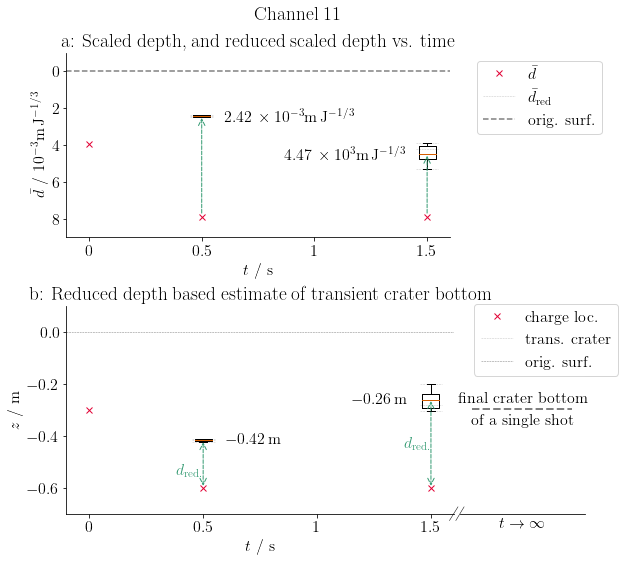

In [47]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 11], fig, "Channel 11")
# fig

### Channel 12

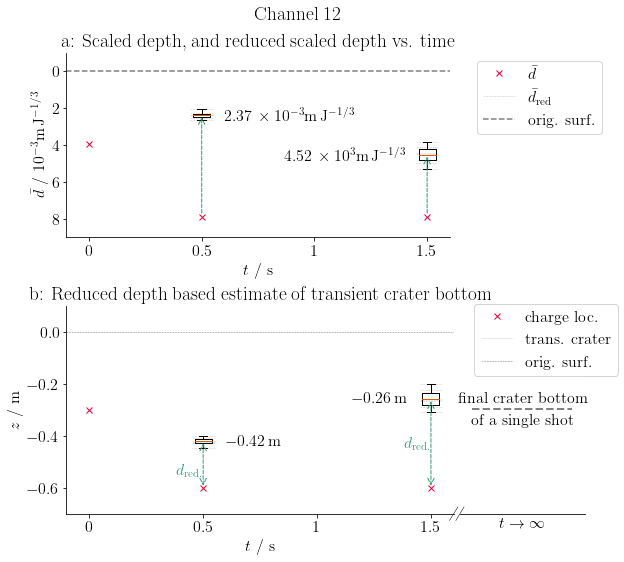

In [48]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 12], fig, "Channel 12")
# fig

### Channel 13

In [49]:
fig = plt.figure()
fig = dredplot(data.loc[data.ch == 13], fig, "Channel 13")
# fig

## Write `dredbar` column to Data Repo